Import All Packages

In [1]:
import pandas as pd
import numpy as np
import time

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
from matplotlib.pyplot import cm
%matplotlib inline

from sklearn.manifold import TSNE

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
# from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import roc_auc_score, accuracy_score
# from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE

C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load All Data

In [20]:
def load_data(maxLines, duplicates):

    """
        Import datasets, select features and define the default-flag collumn.
    """
    
    col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
            'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
            'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
            'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd']
    
    extended_selec_acq = ['LoanID', 'OrLTV', 'LoanPurpose', 'DTIRat', 'PropertyType', 'FTHomeBuyer', 'Channel', 'SellerName','OrInterestRate', 'CreditScore', 'NumBorrow', 'OrDate'] 
    col_acq_subset = extended_selec_acq 
    
    col_per = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
              'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
              'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
              'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
              'FPWA','ServicingIndicator'] 
    
    extended_selec_per = ['LoanID', 'MonthsToMaturity', 'CurrInterestRate', 'ForeclosureDate', 'LoanAge', 'CLDS', 'MaturityDate','ZeroBalCode', 'MonthRep']
    
    col_per_subset =  extended_selec_per 
    
    lines_to_read = maxLines
    aquisition_frame = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/Acquisition_2007Q4.txt', sep='|', names=col_acq, usecols=col_acq_subset, index_col=False, nrows=lines_to_read )
    performance_frame = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/Performance_2007Q4.txt', sep='|', names=col_per, usecols=col_per_subset, index_col=False, nrows=lines_to_read) 

    """ Fix the IDs in the observation set by fixing their reporting date AND requiring that the files are healthy. """
    
    observation_frame = performance_frame[(performance_frame.MonthRep == '12/01/2017') & 
                                (   (performance_frame.CLDS == '0') | 
                                    (performance_frame.CLDS == '1') | 
                                    (performance_frame.CLDS == '2')
                                )
                                ]
    obs_ids = observation_frame.LoanID
    
    """ Load only the observation IDs in the performance frame initially. """
    pf = performance_frame[performance_frame.LoanID.isin(obs_ids)]
    
    """ Keep only the reporting dates that are in our performance period (MM/DD/YYYY format). """
    pf_obs = pf[
                    (pf.MonthRep == '01/01/2018') | 
                    (pf.MonthRep == '02/01/2018') |
                    (pf.MonthRep == '03/01/2018') |
                    (pf.MonthRep == '04/01/2018') |
                    (pf.MonthRep == '05/01/2018') |
                    (pf.MonthRep == '06/01/2018') |
                    (pf.MonthRep == '07/01/2018') |
                    (pf.MonthRep == '08/01/2018') |
                    (pf.MonthRep == '09/01/2018') |
                    (pf.MonthRep == '10/01/2018') |
                    (pf.MonthRep == '11/01/2018') |
                    (pf.MonthRep == '12/01/2018') 
                ]
    
    """ 
    Find the LoanIDs of those loans where a default appears in our performance period.
    """
    pf_obs_defaults = pf_obs[
                            (pf_obs.CLDS != '0') &
                            (pf_obs.CLDS != '1') &
                            (pf_obs.CLDS != '2') &
                            (pf_obs.CLDS != 'X')
                        ].LoanID
    
    pf_obs_defaults.drop_duplicates(keep='last', inplace=True)
    print(len(pf_obs_defaults))
    
    """ Merge the acquisition and performance frames. """
    df = pd.merge(aquisition_frame, observation_frame, on = 'LoanID', how='inner')
    
    df['Default'] = 0
    df.loc[df['LoanID'].isin(pf_obs_defaults), 'Default'] = 1
    
    
    return df

In [21]:
def make_target_var(df):
    df.rename(index=str, columns={'ForeclosureDate': 'Default'}, inplace= True)
    df['Default'].fillna(0, inplace=True)
    df.loc[df['Default'] != 0, 'Default'] = 1

In [22]:
def get_na_columns(df):
    na_columns = df.columns[df.isnull().any()]
    return na_columns

In [23]:
def get_cat_feat(df):
    cat_feat = df.select_dtypes(include=['object']).columns
    return cat_feat

def get_num_feat(df):
    num_feat = df.select_dtypes(exclude=['object']).columns
    return num_feat

In [24]:
def normalize(df):
    df_norm = df
    df_norm = df_norm.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return df_norm

In [25]:
def makeDateNumeric(text):
    numMonths = int(text[:2])
    numYears = int(text[3:7])
    result = (numYears - 2000) * 12 + numMonths
    return result


def makeDayNumeric(text):
    numMonths = int(text[:2])
    numYears = int(text[6:10])
    result = (numYears - 2000) * 12 + numMonths
    return result

def make_dates_numeric(df):
    # TRANSFORM DATES TO NUMBER OF MONTHS (STARTING FROM 01/2000)
    df['MonthRep'] = df['MonthRep'].apply(makeDayNumeric)
    df['OrDate'] = df['OrDate'].apply(makeDateNumeric)
    df['FirstPayment'] = df['FirstPayment'].apply(makeDateNumeric)
    df['MaturityDate'] = df['MaturityDate'].apply(makeDateNumeric)

In [26]:
def to_2D(df):
        # TSNE - Dimentionality reduction
    print ('Training T-SNE ...')

    tsne = TSNE(n_components=2, random_state=1, n_iter=250, verbose=1)
    df_2D = tsne.fit_transform(df)
    df_2D = pd.DataFrame(df_2D)
    return df_2D

In [27]:
def tsne_visual(df):   
        # TSNE - Dimentionality reduction
    print ('Training T-SNE ...')

    tsne = TSNE(n_components=2, random_state=1, n_iter=250, verbose=1)
    df_2D = tsne.fit_transform(df.drop('Default', axis=1))
    df_2D = pd.DataFrame(df_2D)
    
    
    #Making plot
    plt.figure(figsize=(20,10))
    color = cm.rainbow(np.linspace(0,1, max(map(abs, set(df['Default'])))+1))
    for i in range(0, len(df_2D)):
        c1 = plt.scatter(df_2D.iloc[i][0], 
                         df_2D.iloc[i][1],
                     c = color[int(df.iloc[i]['Default'])],
                     marker=r"$ {} $".format(int(df.iloc[i]['Default'])), s=150, edgecolors='none')

    plt.xlabel('T-SNE Dim 1')
    plt.ylabel('T-SNE Dim 2')
    plt.title('Actives')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('Actives' + '.pdf', format='pdf', dpi=900)
    plt.show()

MAIN

In [29]:
df = load_data(100000, False)
# make_dates_numeric(df)

# FORCE FEATURES TO BE INCLUDED
df = df[pd.notnull(df['CreditScore'])]
# df = df[pd.notnull(df['CLDS'])]
df = df[pd.notnull(df['DTIRat'])]

# FORCE FEATURES TO BE EXCLUDED
df = df.drop('LoanID',axis=1)
df = df.drop('CLDS',axis=1)

# FORCE FEATURE TO BE CATEGORICAL
# df['Zip'] = df['Zip'].astype('object',copy=False)
# df['MSA'] = df['MSA'].astype('object',copy=False)


na_columns = get_na_columns(df)
df = df.drop(na_columns,axis=1)

cat_feat = get_cat_feat(df)
cat_data = df[cat_feat]
# cat_data = cat_data.apply(LabelEncoder().fit_transform)

num_feat = get_num_feat(df)
num_data = normalize(df[num_feat])

df = pd.concat([num_data, cat_data], axis=1)
print(df.columns)

17
Index(['OrInterestRate', 'OrLTV', 'NumBorrow', 'DTIRat', 'CreditScore',
       'CurrInterestRate', 'LoanAge', 'MonthsToMaturity', 'Default', 'Channel',
       'SellerName', 'OrDate', 'FTHomeBuyer', 'LoanPurpose', 'PropertyType',
       'MonthRep', 'MaturityDate'],
      dtype='object')


MAIN 2

In [30]:
"""
    Split the target variable from the input variables.
""" 
y = df['Default']
X = df.drop(['Default'], axis=1)

In [31]:
print(y.value_counts())

0.0    144
1.0     16
Name: Default, dtype: int64


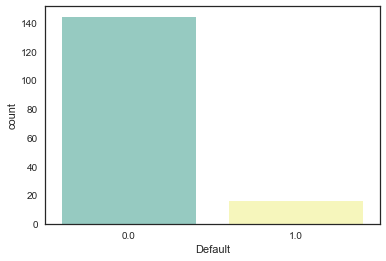

In [32]:
ax = sns.countplot(x="Default", data=df, palette = "Set3")

In [33]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

Before OverSampling, counts of label '1': 16
Before OverSampling, counts of label '0': 144 



In [34]:
#Perform Upsampling Using SMOTE
from imblearn.over_sampling import SMOTENC
categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(categorical_features_indices)

smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

print('After OverSampling, the shape of X: {}'.format(X_res.shape))
print('After OverSampling, the shape of y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

[ 8  9 10 11 12 13 14 15]


ValueError: could not convert string to float: 'B'

In [35]:
"""
    Balance classes with Synthetic Minority Oversampling Technique (SMOTE) or Random Undersampling.
    Choose here either sampling_method = "Random Under Sampling" or "SMOTE". 
    Save n_1 and n_0 separately to apply a correction to the resampling when using the model to predict.
"""     

n_1 = sum(y)
n_0 = len(y) - sum(y)

sm = SMOTE()

X_cols = X.columns
X, y = sm.fit_sample(X, y) # fit_sample takes a dataframe, but returns an array. 
(X, y) = (pd.DataFrame(X, columns=X_cols), pd.Series(y))
print(y.value_counts())

ValueError: could not convert string to float: 'B'

In [36]:
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
# y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [37]:
sm = SMOTE()

X_cols = X.columns
X, y = sm.fit_sample(X, y) # fit_sample takes a dataframe, but returns an array. 
(X, y) = (pd.DataFrame(X, columns=X_cols), pd.Series(y))
print(y.value_counts())

ValueError: could not convert string to float: 'B'

In [38]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([ 8,  9, 10, 11, 12, 13, 14, 15], dtype=int64)

In [39]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [40]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [ ]:
for train_index, test_index in skf.split(X, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # fit model on training data
    model.fit(
        X_train, y_train,
        cat_features=cat_feat,
        eval_set=(X_test, y_test), 
        logging_level='Verbose',  # you can uncomment this for text output
        plot=True);

Learning rate set to 0.063615
0:	learn: 0.6388841	test: 0.6416708	best: 0.6416708 (0)	total: 255ms	remaining: 4m 14s
1:	learn: 0.5928817	test: 0.5980719	best: 0.5980719 (1)	total: 359ms	remaining: 2m 59s
2:	learn: 0.5537857	test: 0.5613870	best: 0.5613870 (2)	total: 471ms	remaining: 2m 36s
3:	learn: 0.5208575	test: 0.5311035	best: 0.5311035 (3)	total: 658ms	remaining: 2m 43s
4:	learn: 0.4912784	test: 0.5057822	best: 0.5057822 (4)	total: 839ms	remaining: 2m 47s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

5:	learn: 0.4641589	test: 0.4846947	best: 0.4846947 (5)	total: 1.19s	remaining: 3m 17s
6:	learn: 0.4425547	test: 0.4664642	best: 0.4664642 (6)	total: 1.33s	remaining: 3m 8s
7:	learn: 0.4248352	test: 0.4505491	best: 0.4505491 (7)	total: 1.39s	remaining: 2m 52s
8:	learn: 0.4075314	test: 0.4358478	best: 0.4358478 (8)	total: 1.59s	remaining: 2m 55s
9:	learn: 0.3948603	test: 0.4252750	best: 0.4252750 (9)	total: 1.72s	remaining: 2m 50s
10:	learn: 0.3833628	test: 0.4167835	best: 0.4167835 (10)	total: 1.83s	remaining: 2m 44s
11:	learn: 0.3703373	test: 0.4070459	best: 0.4070459 (11)	total: 2.13s	remaining: 2m 55s
12:	learn: 0.3603045	test: 0.4025073	best: 0.4025073 (12)	total: 2.32s	remaining: 2m 56s
13:	learn: 0.3531608	test: 0.3960210	best: 0.3960210 (13)	total: 2.44s	remaining: 2m 51s
14:	learn: 0.3464765	test: 0.3896282	best: 0.3896282 (14)	total: 2.6s	remaining: 2m 50s
15:	learn: 0.3395274	test: 0.3876877	best: 0.3876877 (15)	total: 2.94s	remaining: 3m
16:	learn: 0.3291169	test: 0.3808534	

98:	learn: 0.1425694	test: 0.3745072	best: 0.3523665 (81)	total: 21.4s	remaining: 3m 14s
99:	learn: 0.1402906	test: 0.3745663	best: 0.3523665 (81)	total: 21.6s	remaining: 3m 14s
100:	learn: 0.1395507	test: 0.3752916	best: 0.3523665 (81)	total: 21.8s	remaining: 3m 13s
101:	learn: 0.1375395	test: 0.3739468	best: 0.3523665 (81)	total: 22.2s	remaining: 3m 15s
102:	learn: 0.1357390	test: 0.3780088	best: 0.3523665 (81)	total: 22.6s	remaining: 3m 16s
103:	learn: 0.1335678	test: 0.3813888	best: 0.3523665 (81)	total: 22.9s	remaining: 3m 17s
104:	learn: 0.1312376	test: 0.3839238	best: 0.3523665 (81)	total: 23.2s	remaining: 3m 18s
105:	learn: 0.1289063	test: 0.3840617	best: 0.3523665 (81)	total: 23.6s	remaining: 3m 19s
106:	learn: 0.1272050	test: 0.3806875	best: 0.3523665 (81)	total: 24s	remaining: 3m 20s
107:	learn: 0.1261777	test: 0.3806519	best: 0.3523665 (81)	total: 24.3s	remaining: 3m 20s
108:	learn: 0.1244944	test: 0.3846452	best: 0.3523665 (81)	total: 24.7s	remaining: 3m 21s
109:	learn: 0.

190:	learn: 0.0444497	test: 0.4760494	best: 0.3523665 (81)	total: 51.2s	remaining: 3m 36s
191:	learn: 0.0438453	test: 0.4773328	best: 0.3523665 (81)	total: 51.5s	remaining: 3m 36s
192:	learn: 0.0433166	test: 0.4791422	best: 0.3523665 (81)	total: 51.8s	remaining: 3m 36s
193:	learn: 0.0428217	test: 0.4783666	best: 0.3523665 (81)	total: 52.1s	remaining: 3m 36s
194:	learn: 0.0423240	test: 0.4794673	best: 0.3523665 (81)	total: 52.5s	remaining: 3m 36s
195:	learn: 0.0420314	test: 0.4799457	best: 0.3523665 (81)	total: 52.8s	remaining: 3m 36s
196:	learn: 0.0411845	test: 0.4789554	best: 0.3523665 (81)	total: 53.2s	remaining: 3m 36s
197:	learn: 0.0408829	test: 0.4795921	best: 0.3523665 (81)	total: 53.6s	remaining: 3m 37s
198:	learn: 0.0407224	test: 0.4798786	best: 0.3523665 (81)	total: 53.9s	remaining: 3m 37s
199:	learn: 0.0404993	test: 0.4793529	best: 0.3523665 (81)	total: 54.2s	remaining: 3m 36s
200:	learn: 0.0402572	test: 0.4795515	best: 0.3523665 (81)	total: 54.6s	remaining: 3m 36s
201:	learn

281:	learn: 0.0211579	test: 0.5477321	best: 0.3523665 (81)	total: 1m 21s	remaining: 3m 26s
282:	learn: 0.0210151	test: 0.5509404	best: 0.3523665 (81)	total: 1m 21s	remaining: 3m 26s
283:	learn: 0.0207884	test: 0.5519899	best: 0.3523665 (81)	total: 1m 21s	remaining: 3m 26s
284:	learn: 0.0206499	test: 0.5517424	best: 0.3523665 (81)	total: 1m 22s	remaining: 3m 25s
285:	learn: 0.0205711	test: 0.5520803	best: 0.3523665 (81)	total: 1m 22s	remaining: 3m 25s
286:	learn: 0.0204485	test: 0.5523521	best: 0.3523665 (81)	total: 1m 22s	remaining: 3m 25s
287:	learn: 0.0203732	test: 0.5525485	best: 0.3523665 (81)	total: 1m 23s	remaining: 3m 25s
288:	learn: 0.0202784	test: 0.5539944	best: 0.3523665 (81)	total: 1m 23s	remaining: 3m 25s
289:	learn: 0.0202257	test: 0.5536461	best: 0.3523665 (81)	total: 1m 23s	remaining: 3m 25s
290:	learn: 0.0201181	test: 0.5548294	best: 0.3523665 (81)	total: 1m 24s	remaining: 3m 25s
291:	learn: 0.0200866	test: 0.5555705	best: 0.3523665 (81)	total: 1m 24s	remaining: 3m 25s

372:	learn: 0.0127665	test: 0.6047874	best: 0.3523665 (81)	total: 1m 51s	remaining: 3m 6s
373:	learn: 0.0127096	test: 0.6061068	best: 0.3523665 (81)	total: 1m 51s	remaining: 3m 6s
374:	learn: 0.0126507	test: 0.6060433	best: 0.3523665 (81)	total: 1m 51s	remaining: 3m 6s
375:	learn: 0.0126111	test: 0.6065033	best: 0.3523665 (81)	total: 1m 52s	remaining: 3m 6s
376:	learn: 0.0125271	test: 0.6082903	best: 0.3523665 (81)	total: 1m 52s	remaining: 3m 5s
377:	learn: 0.0124876	test: 0.6083522	best: 0.3523665 (81)	total: 1m 52s	remaining: 3m 5s
378:	learn: 0.0123957	test: 0.6077247	best: 0.3523665 (81)	total: 1m 53s	remaining: 3m 5s
379:	learn: 0.0123830	test: 0.6080572	best: 0.3523665 (81)	total: 1m 53s	remaining: 3m 4s
380:	learn: 0.0123165	test: 0.6085718	best: 0.3523665 (81)	total: 1m 53s	remaining: 3m 4s
381:	learn: 0.0122666	test: 0.6076744	best: 0.3523665 (81)	total: 1m 53s	remaining: 3m 4s
382:	learn: 0.0122049	test: 0.6077839	best: 0.3523665 (81)	total: 1m 54s	remaining: 3m 4s
383:	learn

463:	learn: 0.0088205	test: 0.6484282	best: 0.3523665 (81)	total: 2m 21s	remaining: 2m 43s
464:	learn: 0.0087936	test: 0.6491291	best: 0.3523665 (81)	total: 2m 21s	remaining: 2m 42s
465:	learn: 0.0087594	test: 0.6496611	best: 0.3523665 (81)	total: 2m 21s	remaining: 2m 42s
466:	learn: 0.0087369	test: 0.6498835	best: 0.3523665 (81)	total: 2m 22s	remaining: 2m 42s
467:	learn: 0.0086945	test: 0.6497359	best: 0.3523665 (81)	total: 2m 22s	remaining: 2m 42s
468:	learn: 0.0086780	test: 0.6498625	best: 0.3523665 (81)	total: 2m 22s	remaining: 2m 41s
469:	learn: 0.0086419	test: 0.6509660	best: 0.3523665 (81)	total: 2m 23s	remaining: 2m 41s
470:	learn: 0.0086112	test: 0.6521552	best: 0.3523665 (81)	total: 2m 23s	remaining: 2m 41s
471:	learn: 0.0086002	test: 0.6527319	best: 0.3523665 (81)	total: 2m 23s	remaining: 2m 40s
472:	learn: 0.0085733	test: 0.6535743	best: 0.3523665 (81)	total: 2m 24s	remaining: 2m 40s
473:	learn: 0.0085366	test: 0.6542398	best: 0.3523665 (81)	total: 2m 24s	remaining: 2m 40s

554:	learn: 0.0066510	test: 0.6872310	best: 0.3523665 (81)	total: 2m 52s	remaining: 2m 18s
555:	learn: 0.0066312	test: 0.6876671	best: 0.3523665 (81)	total: 2m 53s	remaining: 2m 18s
556:	learn: 0.0066117	test: 0.6888656	best: 0.3523665 (81)	total: 2m 53s	remaining: 2m 17s
557:	learn: 0.0065828	test: 0.6897903	best: 0.3523665 (81)	total: 2m 53s	remaining: 2m 17s
558:	learn: 0.0065434	test: 0.6892824	best: 0.3523665 (81)	total: 2m 53s	remaining: 2m 17s
559:	learn: 0.0065122	test: 0.6898867	best: 0.3523665 (81)	total: 2m 54s	remaining: 2m 16s
560:	learn: 0.0064890	test: 0.6902549	best: 0.3523665 (81)	total: 2m 54s	remaining: 2m 16s
561:	learn: 0.0064749	test: 0.6907003	best: 0.3523665 (81)	total: 2m 55s	remaining: 2m 16s
562:	learn: 0.0064361	test: 0.6903825	best: 0.3523665 (81)	total: 2m 55s	remaining: 2m 16s
563:	learn: 0.0064208	test: 0.6908118	best: 0.3523665 (81)	total: 2m 55s	remaining: 2m 15s
564:	learn: 0.0064142	test: 0.6905850	best: 0.3523665 (81)	total: 2m 55s	remaining: 2m 15s

645:	learn: 0.0051242	test: 0.7162344	best: 0.3523665 (81)	total: 3m 22s	remaining: 1m 51s
646:	learn: 0.0051046	test: 0.7165768	best: 0.3523665 (81)	total: 3m 23s	remaining: 1m 50s
647:	learn: 0.0050882	test: 0.7170945	best: 0.3523665 (81)	total: 3m 23s	remaining: 1m 50s
648:	learn: 0.0050788	test: 0.7175268	best: 0.3523665 (81)	total: 3m 23s	remaining: 1m 50s
649:	learn: 0.0050594	test: 0.7173210	best: 0.3523665 (81)	total: 3m 24s	remaining: 1m 49s
650:	learn: 0.0050516	test: 0.7175222	best: 0.3523665 (81)	total: 3m 24s	remaining: 1m 49s
651:	learn: 0.0050370	test: 0.7177662	best: 0.3523665 (81)	total: 3m 24s	remaining: 1m 49s
652:	learn: 0.0050116	test: 0.7191458	best: 0.3523665 (81)	total: 3m 25s	remaining: 1m 48s
653:	learn: 0.0050039	test: 0.7192891	best: 0.3523665 (81)	total: 3m 25s	remaining: 1m 48s
654:	learn: 0.0049889	test: 0.7196242	best: 0.3523665 (81)	total: 3m 25s	remaining: 1m 48s
655:	learn: 0.0049708	test: 0.7197745	best: 0.3523665 (81)	total: 3m 25s	remaining: 1m 48s

736:	learn: 0.0042001	test: 0.7404425	best: 0.3523665 (81)	total: 3m 53s	remaining: 1m 23s
737:	learn: 0.0041944	test: 0.7412247	best: 0.3523665 (81)	total: 3m 53s	remaining: 1m 22s
738:	learn: 0.0041865	test: 0.7413968	best: 0.3523665 (81)	total: 3m 54s	remaining: 1m 22s
739:	learn: 0.0041764	test: 0.7417614	best: 0.3523665 (81)	total: 3m 54s	remaining: 1m 22s
740:	learn: 0.0041609	test: 0.7418921	best: 0.3523665 (81)	total: 3m 54s	remaining: 1m 22s
741:	learn: 0.0041476	test: 0.7414327	best: 0.3523665 (81)	total: 3m 55s	remaining: 1m 21s
742:	learn: 0.0041388	test: 0.7417983	best: 0.3523665 (81)	total: 3m 55s	remaining: 1m 21s
743:	learn: 0.0041329	test: 0.7419512	best: 0.3523665 (81)	total: 3m 55s	remaining: 1m 21s
744:	learn: 0.0041277	test: 0.7427838	best: 0.3523665 (81)	total: 3m 56s	remaining: 1m 20s
745:	learn: 0.0041228	test: 0.7429455	best: 0.3523665 (81)	total: 3m 56s	remaining: 1m 20s
746:	learn: 0.0041145	test: 0.7430932	best: 0.3523665 (81)	total: 3m 56s	remaining: 1m 20s

828:	learn: 0.0035245	test: 0.7609693	best: 0.3523665 (81)	total: 4m 26s	remaining: 54.9s
829:	learn: 0.0035202	test: 0.7611911	best: 0.3523665 (81)	total: 4m 26s	remaining: 54.6s
830:	learn: 0.0035162	test: 0.7608886	best: 0.3523665 (81)	total: 4m 26s	remaining: 54.3s
831:	learn: 0.0035135	test: 0.7610854	best: 0.3523665 (81)	total: 4m 27s	remaining: 54s
832:	learn: 0.0035045	test: 0.7610279	best: 0.3523665 (81)	total: 4m 27s	remaining: 53.6s
833:	learn: 0.0034988	test: 0.7610789	best: 0.3523665 (81)	total: 4m 27s	remaining: 53.3s
834:	learn: 0.0034963	test: 0.7614534	best: 0.3523665 (81)	total: 4m 28s	remaining: 53s
835:	learn: 0.0034902	test: 0.7621864	best: 0.3523665 (81)	total: 4m 28s	remaining: 52.7s
836:	learn: 0.0034880	test: 0.7623535	best: 0.3523665 (81)	total: 4m 29s	remaining: 52.4s
837:	learn: 0.0034833	test: 0.7628489	best: 0.3523665 (81)	total: 4m 29s	remaining: 52.1s
838:	learn: 0.0034777	test: 0.7629497	best: 0.3523665 (81)	total: 4m 29s	remaining: 51.8s
839:	learn: 0.

920:	learn: 0.0030652	test: 0.7709113	best: 0.3523665 (81)	total: 5m 18s	remaining: 27.3s
921:	learn: 0.0030608	test: 0.7714365	best: 0.3523665 (81)	total: 5m 19s	remaining: 27s
922:	learn: 0.0030575	test: 0.7714489	best: 0.3523665 (81)	total: 5m 19s	remaining: 26.7s
923:	learn: 0.0030548	test: 0.7712987	best: 0.3523665 (81)	total: 5m 20s	remaining: 26.4s
924:	learn: 0.0030517	test: 0.7713377	best: 0.3523665 (81)	total: 5m 20s	remaining: 26s
925:	learn: 0.0030476	test: 0.7716993	best: 0.3523665 (81)	total: 5m 21s	remaining: 25.7s
926:	learn: 0.0030411	test: 0.7716426	best: 0.3523665 (81)	total: 5m 21s	remaining: 25.3s
927:	learn: 0.0030362	test: 0.7720614	best: 0.3523665 (81)	total: 5m 22s	remaining: 25s
928:	learn: 0.0030298	test: 0.7724520	best: 0.3523665 (81)	total: 5m 22s	remaining: 24.7s
929:	learn: 0.0030260	test: 0.7725993	best: 0.3523665 (81)	total: 5m 23s	remaining: 24.3s
930:	learn: 0.0030200	test: 0.7729814	best: 0.3523665 (81)	total: 5m 24s	remaining: 24s
931:	learn: 0.0030

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.063615
0:	learn: 0.6397640	test: 0.6443528	best: 0.6443528 (0)	total: 327ms	remaining: 5m 26s
1:	learn: 0.5932295	test: 0.5990231	best: 0.5990231 (1)	total: 460ms	remaining: 3m 49s
2:	learn: 0.5530123	test: 0.5620296	best: 0.5620296 (2)	total: 825ms	remaining: 4m 34s
3:	learn: 0.5189405	test: 0.5303222	best: 0.5303222 (3)	total: 899ms	remaining: 3m 43s
4:	learn: 0.4902946	test: 0.5038651	best: 0.5038651 (4)	total: 1.01s	remaining: 3m 20s
5:	learn: 0.4657589	test: 0.4812779	best: 0.4812779 (5)	total: 1.13s	remaining: 3m 6s
6:	learn: 0.4446389	test: 0.4621051	best: 0.4621051 (6)	total: 1.19s	remaining: 2m 49s
7:	learn: 0.4266400	test: 0.4459279	best: 0.4459279 (7)	total: 1.31s	remaining: 2m 42s
8:	learn: 0.4109075	test: 0.4329750	best: 0.4329750 (8)	total: 1.66s	remaining: 3m 2s
9:	learn: 0.3977956	test: 0.4213915	best: 0.4213915 (9)	total: 1.84s	remaining: 3m 2s
10:	learn: 0.3865904	test: 0.4116185	best: 0.4116185 (10)	total: 1.92s	remaining: 2m 52s
11:	learn: 0.3

93:	learn: 0.1409649	test: 0.3099092	best: 0.3053399 (80)	total: 18.8s	remaining: 3m 1s
94:	learn: 0.1384397	test: 0.3083919	best: 0.3053399 (80)	total: 19.1s	remaining: 3m 2s
95:	learn: 0.1368259	test: 0.3088843	best: 0.3053399 (80)	total: 19.4s	remaining: 3m 2s
96:	learn: 0.1341373	test: 0.3091368	best: 0.3053399 (80)	total: 19.7s	remaining: 3m 3s
97:	learn: 0.1318529	test: 0.3084720	best: 0.3053399 (80)	total: 20s	remaining: 3m 4s
98:	learn: 0.1296439	test: 0.3044920	best: 0.3044920 (98)	total: 20.3s	remaining: 3m 4s
99:	learn: 0.1285512	test: 0.3047369	best: 0.3044920 (98)	total: 20.6s	remaining: 3m 5s
100:	learn: 0.1261884	test: 0.3031203	best: 0.3031203 (100)	total: 20.9s	remaining: 3m 5s
101:	learn: 0.1248223	test: 0.3009567	best: 0.3009567 (101)	total: 21.2s	remaining: 3m 6s
102:	learn: 0.1238096	test: 0.3009540	best: 0.3009540 (102)	total: 21.5s	remaining: 3m 7s
103:	learn: 0.1231014	test: 0.2988894	best: 0.2988894 (103)	total: 21.8s	remaining: 3m 7s
104:	learn: 0.1223858	test

184:	learn: 0.0442594	test: 0.3490545	best: 0.2907756 (119)	total: 48.6s	remaining: 3m 34s
185:	learn: 0.0437959	test: 0.3503420	best: 0.2907756 (119)	total: 48.9s	remaining: 3m 33s
186:	learn: 0.0435841	test: 0.3523469	best: 0.2907756 (119)	total: 49.2s	remaining: 3m 33s
187:	learn: 0.0433566	test: 0.3527357	best: 0.2907756 (119)	total: 49.8s	remaining: 3m 35s
188:	learn: 0.0430753	test: 0.3533497	best: 0.2907756 (119)	total: 50.3s	remaining: 3m 35s
189:	learn: 0.0426581	test: 0.3553894	best: 0.2907756 (119)	total: 50.8s	remaining: 3m 36s
190:	learn: 0.0423854	test: 0.3567992	best: 0.2907756 (119)	total: 51.3s	remaining: 3m 37s
191:	learn: 0.0416983	test: 0.3545934	best: 0.2907756 (119)	total: 52s	remaining: 3m 39s
192:	learn: 0.0410613	test: 0.3541810	best: 0.2907756 (119)	total: 52.7s	remaining: 3m 40s
193:	learn: 0.0407794	test: 0.3550453	best: 0.2907756 (119)	total: 53s	remaining: 3m 40s
194:	learn: 0.0405573	test: 0.3553483	best: 0.2907756 (119)	total: 53.4s	remaining: 3m 40s
195

274:	learn: 0.0201942	test: 0.3727689	best: 0.2907756 (119)	total: 1m 20s	remaining: 3m 31s
275:	learn: 0.0201449	test: 0.3729126	best: 0.2907756 (119)	total: 1m 20s	remaining: 3m 31s
276:	learn: 0.0199749	test: 0.3739124	best: 0.2907756 (119)	total: 1m 21s	remaining: 3m 31s
277:	learn: 0.0198538	test: 0.3737402	best: 0.2907756 (119)	total: 1m 21s	remaining: 3m 31s
278:	learn: 0.0197204	test: 0.3743798	best: 0.2907756 (119)	total: 1m 21s	remaining: 3m 31s
279:	learn: 0.0195386	test: 0.3743921	best: 0.2907756 (119)	total: 1m 22s	remaining: 3m 31s
280:	learn: 0.0194141	test: 0.3741395	best: 0.2907756 (119)	total: 1m 22s	remaining: 3m 31s
281:	learn: 0.0192542	test: 0.3740445	best: 0.2907756 (119)	total: 1m 22s	remaining: 3m 31s
282:	learn: 0.0190914	test: 0.3740514	best: 0.2907756 (119)	total: 1m 23s	remaining: 3m 30s
283:	learn: 0.0189325	test: 0.3757428	best: 0.2907756 (119)	total: 1m 23s	remaining: 3m 30s
284:	learn: 0.0187481	test: 0.3763777	best: 0.2907756 (119)	total: 1m 23s	remain

364:	learn: 0.0122847	test: 0.3970781	best: 0.2907756 (119)	total: 1m 50s	remaining: 3m 13s
365:	learn: 0.0122316	test: 0.3972078	best: 0.2907756 (119)	total: 1m 51s	remaining: 3m 12s
366:	learn: 0.0121618	test: 0.3973233	best: 0.2907756 (119)	total: 1m 51s	remaining: 3m 12s
367:	learn: 0.0121405	test: 0.3973188	best: 0.2907756 (119)	total: 1m 51s	remaining: 3m 12s
368:	learn: 0.0120899	test: 0.3987241	best: 0.2907756 (119)	total: 1m 52s	remaining: 3m 12s
369:	learn: 0.0120439	test: 0.3986221	best: 0.2907756 (119)	total: 1m 52s	remaining: 3m 12s
370:	learn: 0.0120034	test: 0.3993171	best: 0.2907756 (119)	total: 1m 53s	remaining: 3m 11s
371:	learn: 0.0119187	test: 0.3987713	best: 0.2907756 (119)	total: 1m 53s	remaining: 3m 11s
372:	learn: 0.0117915	test: 0.4002158	best: 0.2907756 (119)	total: 1m 53s	remaining: 3m 11s
373:	learn: 0.0117343	test: 0.3997262	best: 0.2907756 (119)	total: 1m 54s	remaining: 3m 10s
374:	learn: 0.0116845	test: 0.3997789	best: 0.2907756 (119)	total: 1m 54s	remain

455:	learn: 0.0088396	test: 0.4168803	best: 0.2907756 (119)	total: 2m 22s	remaining: 2m 49s
456:	learn: 0.0088067	test: 0.4170286	best: 0.2907756 (119)	total: 2m 22s	remaining: 2m 49s
457:	learn: 0.0087917	test: 0.4167622	best: 0.2907756 (119)	total: 2m 22s	remaining: 2m 49s
458:	learn: 0.0087805	test: 0.4168473	best: 0.2907756 (119)	total: 2m 23s	remaining: 2m 48s
459:	learn: 0.0087480	test: 0.4172947	best: 0.2907756 (119)	total: 2m 23s	remaining: 2m 48s
460:	learn: 0.0087256	test: 0.4174709	best: 0.2907756 (119)	total: 2m 24s	remaining: 2m 48s
461:	learn: 0.0086893	test: 0.4176506	best: 0.2907756 (119)	total: 2m 24s	remaining: 2m 48s
462:	learn: 0.0086747	test: 0.4181309	best: 0.2907756 (119)	total: 2m 24s	remaining: 2m 47s
463:	learn: 0.0086570	test: 0.4177401	best: 0.2907756 (119)	total: 2m 25s	remaining: 2m 47s
464:	learn: 0.0085981	test: 0.4188022	best: 0.2907756 (119)	total: 2m 25s	remaining: 2m 47s
465:	learn: 0.0085579	test: 0.4193543	best: 0.2907756 (119)	total: 2m 25s	remain

545:	learn: 0.0067441	test: 0.4325509	best: 0.2907756 (119)	total: 2m 54s	remaining: 2m 24s
546:	learn: 0.0067160	test: 0.4330811	best: 0.2907756 (119)	total: 2m 54s	remaining: 2m 24s
547:	learn: 0.0066902	test: 0.4330220	best: 0.2907756 (119)	total: 2m 54s	remaining: 2m 24s
548:	learn: 0.0066676	test: 0.4337308	best: 0.2907756 (119)	total: 2m 55s	remaining: 2m 23s
549:	learn: 0.0066401	test: 0.4341072	best: 0.2907756 (119)	total: 2m 55s	remaining: 2m 23s
550:	learn: 0.0066254	test: 0.4340166	best: 0.2907756 (119)	total: 2m 55s	remaining: 2m 23s
551:	learn: 0.0066014	test: 0.4340916	best: 0.2907756 (119)	total: 2m 56s	remaining: 2m 23s
552:	learn: 0.0065909	test: 0.4344241	best: 0.2907756 (119)	total: 2m 56s	remaining: 2m 22s
553:	learn: 0.0065775	test: 0.4338463	best: 0.2907756 (119)	total: 2m 56s	remaining: 2m 22s
554:	learn: 0.0065637	test: 0.4335409	best: 0.2907756 (119)	total: 2m 57s	remaining: 2m 22s
555:	learn: 0.0065260	test: 0.4343530	best: 0.2907756 (119)	total: 2m 57s	remain

635:	learn: 0.0054123	test: 0.4428377	best: 0.2907756 (119)	total: 3m 26s	remaining: 1m 57s
636:	learn: 0.0054033	test: 0.4429677	best: 0.2907756 (119)	total: 3m 26s	remaining: 1m 57s
637:	learn: 0.0053987	test: 0.4427615	best: 0.2907756 (119)	total: 3m 26s	remaining: 1m 57s
638:	learn: 0.0053755	test: 0.4433654	best: 0.2907756 (119)	total: 3m 27s	remaining: 1m 57s
639:	learn: 0.0053629	test: 0.4431246	best: 0.2907756 (119)	total: 3m 27s	remaining: 1m 56s
640:	learn: 0.0053521	test: 0.4430192	best: 0.2907756 (119)	total: 3m 27s	remaining: 1m 56s
641:	learn: 0.0053383	test: 0.4431251	best: 0.2907756 (119)	total: 3m 28s	remaining: 1m 56s
642:	learn: 0.0053341	test: 0.4432912	best: 0.2907756 (119)	total: 3m 28s	remaining: 1m 55s
643:	learn: 0.0053279	test: 0.4442009	best: 0.2907756 (119)	total: 3m 28s	remaining: 1m 55s
644:	learn: 0.0053195	test: 0.4445841	best: 0.2907756 (119)	total: 3m 29s	remaining: 1m 55s
645:	learn: 0.0052930	test: 0.4437723	best: 0.2907756 (119)	total: 3m 29s	remain

725:	learn: 0.0045082	test: 0.4520619	best: 0.2907756 (119)	total: 3m 59s	remaining: 1m 30s
726:	learn: 0.0045019	test: 0.4522291	best: 0.2907756 (119)	total: 4m	remaining: 1m 30s
727:	learn: 0.0044955	test: 0.4524919	best: 0.2907756 (119)	total: 4m	remaining: 1m 29s
728:	learn: 0.0044856	test: 0.4524902	best: 0.2907756 (119)	total: 4m 1s	remaining: 1m 29s
729:	learn: 0.0044754	test: 0.4531145	best: 0.2907756 (119)	total: 4m 1s	remaining: 1m 29s
730:	learn: 0.0044649	test: 0.4528724	best: 0.2907756 (119)	total: 4m 2s	remaining: 1m 29s
731:	learn: 0.0044523	test: 0.4526816	best: 0.2907756 (119)	total: 4m 2s	remaining: 1m 28s
732:	learn: 0.0044377	test: 0.4533795	best: 0.2907756 (119)	total: 4m 2s	remaining: 1m 28s
733:	learn: 0.0044346	test: 0.4536773	best: 0.2907756 (119)	total: 4m 3s	remaining: 1m 28s
734:	learn: 0.0044264	test: 0.4536925	best: 0.2907756 (119)	total: 4m 3s	remaining: 1m 27s
735:	learn: 0.0044208	test: 0.4539854	best: 0.2907756 (119)	total: 4m 3s	remaining: 1m 27s
736:

815:	learn: 0.0038179	test: 0.4617653	best: 0.2907756 (119)	total: 4m 32s	remaining: 1m 1s
816:	learn: 0.0038131	test: 0.4618588	best: 0.2907756 (119)	total: 4m 32s	remaining: 1m 1s
817:	learn: 0.0038087	test: 0.4621023	best: 0.2907756 (119)	total: 4m 32s	remaining: 1m
818:	learn: 0.0037889	test: 0.4632501	best: 0.2907756 (119)	total: 4m 33s	remaining: 1m
819:	learn: 0.0037841	test: 0.4635472	best: 0.2907756 (119)	total: 4m 33s	remaining: 1m
820:	learn: 0.0037800	test: 0.4635292	best: 0.2907756 (119)	total: 4m 33s	remaining: 59.7s
821:	learn: 0.0037719	test: 0.4635277	best: 0.2907756 (119)	total: 4m 34s	remaining: 59.4s
822:	learn: 0.0037655	test: 0.4638623	best: 0.2907756 (119)	total: 4m 34s	remaining: 59.1s
823:	learn: 0.0037585	test: 0.4643169	best: 0.2907756 (119)	total: 4m 34s	remaining: 58.7s
824:	learn: 0.0037546	test: 0.4642031	best: 0.2907756 (119)	total: 4m 35s	remaining: 58.4s
825:	learn: 0.0037412	test: 0.4643722	best: 0.2907756 (119)	total: 4m 35s	remaining: 58s
826:	learn

906:	learn: 0.0033454	test: 0.4716362	best: 0.2907756 (119)	total: 5m 5s	remaining: 31.3s
907:	learn: 0.0033402	test: 0.4715908	best: 0.2907756 (119)	total: 5m 5s	remaining: 31s
908:	learn: 0.0033378	test: 0.4717019	best: 0.2907756 (119)	total: 5m 6s	remaining: 30.6s
909:	learn: 0.0033332	test: 0.4717425	best: 0.2907756 (119)	total: 5m 6s	remaining: 30.3s
910:	learn: 0.0033297	test: 0.4719944	best: 0.2907756 (119)	total: 5m 6s	remaining: 30s
911:	learn: 0.0033266	test: 0.4719894	best: 0.2907756 (119)	total: 5m 7s	remaining: 29.6s
912:	learn: 0.0033227	test: 0.4720722	best: 0.2907756 (119)	total: 5m 7s	remaining: 29.3s
913:	learn: 0.0033189	test: 0.4721201	best: 0.2907756 (119)	total: 5m 7s	remaining: 29s
914:	learn: 0.0033169	test: 0.4720293	best: 0.2907756 (119)	total: 5m 8s	remaining: 28.6s
915:	learn: 0.0033124	test: 0.4722275	best: 0.2907756 (119)	total: 5m 8s	remaining: 28.3s
916:	learn: 0.0033021	test: 0.4726246	best: 0.2907756 (119)	total: 5m 8s	remaining: 28s
917:	learn: 0.0032

997:	learn: 0.0029705	test: 0.4774389	best: 0.2907756 (119)	total: 5m 38s	remaining: 678ms
998:	learn: 0.0029649	test: 0.4776185	best: 0.2907756 (119)	total: 5m 38s	remaining: 339ms
999:	learn: 0.0029618	test: 0.4776331	best: 0.2907756 (119)	total: 5m 38s	remaining: 0us

bestTest = 0.2907756234
bestIteration = 119

Shrink model to first 120 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.063615
0:	learn: 0.6388841	test: 0.6416708	best: 0.6416708 (0)	total: 50.6ms	remaining: 50.5s
1:	learn: 0.5928817	test: 0.5980719	best: 0.5980719 (1)	total: 128ms	remaining: 1m 4s
2:	learn: 0.5537857	test: 0.5613870	best: 0.5613870 (2)	total: 225ms	remaining: 1m 14s
3:	learn: 0.5210784	test: 0.5305656	best: 0.5305656 (3)	total: 387ms	remaining: 1m 36s
4:	learn: 0.4924489	test: 0.5044686	best: 0.5044686 (4)	total: 593ms	remaining: 1m 57s
5:	learn: 0.4681398	test: 0.4861037	best: 0.4861037 (5)	total: 824ms	remaining: 2m 16s
6:	learn: 0.4425728	test: 0.4628116	best: 0.4628116 (6)	total: 1.07s	remaining: 2m 32s
7:	learn: 0.4255743	test: 0.4473579	best: 0.4473579 (7)	total: 1.29s	remaining: 2m 40s
8:	learn: 0.4077301	test: 0.4351583	best: 0.4351583 (8)	total: 1.39s	remaining: 2m 32s
9:	learn: 0.3920837	test: 0.4256122	best: 0.4256122 (9)	total: 1.66s	remaining: 2m 43s
10:	learn: 0.3811507	test: 0.4154690	best: 0.4154690 (10)	total: 1.71s	remaining: 2m 33s
11:	learn: 0

93:	learn: 0.1482450	test: 0.3803718	best: 0.3510173 (69)	total: 20.9s	remaining: 3m 21s
94:	learn: 0.1454910	test: 0.3832798	best: 0.3510173 (69)	total: 21.2s	remaining: 3m 21s
95:	learn: 0.1441668	test: 0.3885955	best: 0.3510173 (69)	total: 21.5s	remaining: 3m 22s
96:	learn: 0.1394606	test: 0.3888249	best: 0.3510173 (69)	total: 21.9s	remaining: 3m 23s
97:	learn: 0.1375260	test: 0.3905462	best: 0.3510173 (69)	total: 22.1s	remaining: 3m 23s
98:	learn: 0.1363377	test: 0.3943406	best: 0.3510173 (69)	total: 22.4s	remaining: 3m 24s
99:	learn: 0.1331907	test: 0.3955346	best: 0.3510173 (69)	total: 22.8s	remaining: 3m 24s
100:	learn: 0.1314694	test: 0.3955410	best: 0.3510173 (69)	total: 23s	remaining: 3m 25s
101:	learn: 0.1309190	test: 0.3985383	best: 0.3510173 (69)	total: 23.4s	remaining: 3m 25s
102:	learn: 0.1279076	test: 0.3946487	best: 0.3510173 (69)	total: 23.7s	remaining: 3m 26s
103:	learn: 0.1264881	test: 0.3938416	best: 0.3510173 (69)	total: 24s	remaining: 3m 26s
104:	learn: 0.1232460

185:	learn: 0.0512157	test: 0.4762365	best: 0.3510173 (69)	total: 52.6s	remaining: 3m 50s
186:	learn: 0.0506520	test: 0.4791547	best: 0.3510173 (69)	total: 53s	remaining: 3m 50s
187:	learn: 0.0499683	test: 0.4806583	best: 0.3510173 (69)	total: 53.3s	remaining: 3m 50s
188:	learn: 0.0497394	test: 0.4806533	best: 0.3510173 (69)	total: 53.6s	remaining: 3m 50s
189:	learn: 0.0492929	test: 0.4820033	best: 0.3510173 (69)	total: 53.9s	remaining: 3m 49s
190:	learn: 0.0486769	test: 0.4815716	best: 0.3510173 (69)	total: 54.2s	remaining: 3m 49s
191:	learn: 0.0482637	test: 0.4822224	best: 0.3510173 (69)	total: 54.5s	remaining: 3m 49s
192:	learn: 0.0478381	test: 0.4822403	best: 0.3510173 (69)	total: 54.9s	remaining: 3m 49s
193:	learn: 0.0475570	test: 0.4842844	best: 0.3510173 (69)	total: 55.3s	remaining: 3m 49s
194:	learn: 0.0470339	test: 0.4838595	best: 0.3510173 (69)	total: 55.7s	remaining: 3m 49s
195:	learn: 0.0462865	test: 0.4857352	best: 0.3510173 (69)	total: 56s	remaining: 3m 49s
196:	learn: 0.

276:	learn: 0.0227258	test: 0.5328073	best: 0.3510173 (69)	total: 1m 23s	remaining: 3m 37s
277:	learn: 0.0226668	test: 0.5349933	best: 0.3510173 (69)	total: 1m 23s	remaining: 3m 37s
278:	learn: 0.0225958	test: 0.5352731	best: 0.3510173 (69)	total: 1m 24s	remaining: 3m 37s
279:	learn: 0.0224543	test: 0.5358551	best: 0.3510173 (69)	total: 1m 24s	remaining: 3m 36s
280:	learn: 0.0223645	test: 0.5361125	best: 0.3510173 (69)	total: 1m 24s	remaining: 3m 36s
281:	learn: 0.0221784	test: 0.5372405	best: 0.3510173 (69)	total: 1m 24s	remaining: 3m 36s
282:	learn: 0.0219715	test: 0.5389227	best: 0.3510173 (69)	total: 1m 25s	remaining: 3m 36s
283:	learn: 0.0218988	test: 0.5390516	best: 0.3510173 (69)	total: 1m 25s	remaining: 3m 35s
284:	learn: 0.0215357	test: 0.5403765	best: 0.3510173 (69)	total: 1m 25s	remaining: 3m 35s
285:	learn: 0.0212060	test: 0.5408939	best: 0.3510173 (69)	total: 1m 26s	remaining: 3m 35s
286:	learn: 0.0211810	test: 0.5412562	best: 0.3510173 (69)	total: 1m 26s	remaining: 3m 34s

367:	learn: 0.0137827	test: 0.5726847	best: 0.3510173 (69)	total: 1m 54s	remaining: 3m 16s
368:	learn: 0.0137506	test: 0.5723871	best: 0.3510173 (69)	total: 1m 54s	remaining: 3m 15s
369:	learn: 0.0136961	test: 0.5724375	best: 0.3510173 (69)	total: 1m 54s	remaining: 3m 15s
370:	learn: 0.0136314	test: 0.5737343	best: 0.3510173 (69)	total: 1m 55s	remaining: 3m 15s
371:	learn: 0.0135766	test: 0.5747316	best: 0.3510173 (69)	total: 1m 55s	remaining: 3m 14s
372:	learn: 0.0135372	test: 0.5749814	best: 0.3510173 (69)	total: 1m 55s	remaining: 3m 14s
373:	learn: 0.0135102	test: 0.5748052	best: 0.3510173 (69)	total: 1m 56s	remaining: 3m 14s
374:	learn: 0.0134551	test: 0.5762494	best: 0.3510173 (69)	total: 1m 56s	remaining: 3m 14s
375:	learn: 0.0134312	test: 0.5762689	best: 0.3510173 (69)	total: 1m 56s	remaining: 3m 13s
376:	learn: 0.0133991	test: 0.5764477	best: 0.3510173 (69)	total: 1m 57s	remaining: 3m 13s
377:	learn: 0.0133151	test: 0.5769953	best: 0.3510173 (69)	total: 1m 57s	remaining: 3m 13s

458:	learn: 0.0097277	test: 0.5987900	best: 0.3510173 (69)	total: 2m 26s	remaining: 2m 53s
459:	learn: 0.0096726	test: 0.5989426	best: 0.3510173 (69)	total: 2m 27s	remaining: 2m 52s
460:	learn: 0.0096188	test: 0.5998189	best: 0.3510173 (69)	total: 2m 27s	remaining: 2m 52s
461:	learn: 0.0095689	test: 0.6007618	best: 0.3510173 (69)	total: 2m 27s	remaining: 2m 52s
462:	learn: 0.0095501	test: 0.6016500	best: 0.3510173 (69)	total: 2m 28s	remaining: 2m 51s
463:	learn: 0.0095233	test: 0.6007050	best: 0.3510173 (69)	total: 2m 28s	remaining: 2m 51s
464:	learn: 0.0095012	test: 0.6006169	best: 0.3510173 (69)	total: 2m 28s	remaining: 2m 51s
465:	learn: 0.0094891	test: 0.6010453	best: 0.3510173 (69)	total: 2m 29s	remaining: 2m 50s
466:	learn: 0.0094564	test: 0.6014514	best: 0.3510173 (69)	total: 2m 29s	remaining: 2m 50s
467:	learn: 0.0093843	test: 0.6016262	best: 0.3510173 (69)	total: 2m 30s	remaining: 2m 50s
468:	learn: 0.0093247	test: 0.6016312	best: 0.3510173 (69)	total: 2m 30s	remaining: 2m 50s

549:	learn: 0.0072428	test: 0.6231335	best: 0.3510173 (69)	total: 2m 58s	remaining: 2m 26s
550:	learn: 0.0072356	test: 0.6234312	best: 0.3510173 (69)	total: 2m 59s	remaining: 2m 26s
551:	learn: 0.0072246	test: 0.6236935	best: 0.3510173 (69)	total: 2m 59s	remaining: 2m 25s
552:	learn: 0.0071976	test: 0.6238564	best: 0.3510173 (69)	total: 2m 59s	remaining: 2m 25s
553:	learn: 0.0071672	test: 0.6243417	best: 0.3510173 (69)	total: 3m	remaining: 2m 25s
554:	learn: 0.0071534	test: 0.6248739	best: 0.3510173 (69)	total: 3m	remaining: 2m 24s
555:	learn: 0.0071354	test: 0.6250885	best: 0.3510173 (69)	total: 3m	remaining: 2m 24s
556:	learn: 0.0070917	test: 0.6252164	best: 0.3510173 (69)	total: 3m 1s	remaining: 2m 24s
557:	learn: 0.0070797	test: 0.6253555	best: 0.3510173 (69)	total: 3m 1s	remaining: 2m 23s
558:	learn: 0.0070638	test: 0.6256306	best: 0.3510173 (69)	total: 3m 1s	remaining: 2m 23s
559:	learn: 0.0070444	test: 0.6266651	best: 0.3510173 (69)	total: 3m 2s	remaining: 2m 23s
560:	learn: 0.0

640:	learn: 0.0057724	test: 0.6410176	best: 0.3510173 (69)	total: 3m 30s	remaining: 1m 57s
641:	learn: 0.0057599	test: 0.6406384	best: 0.3510173 (69)	total: 3m 30s	remaining: 1m 57s
642:	learn: 0.0057550	test: 0.6406666	best: 0.3510173 (69)	total: 3m 30s	remaining: 1m 57s
643:	learn: 0.0057407	test: 0.6411518	best: 0.3510173 (69)	total: 3m 31s	remaining: 1m 56s
644:	learn: 0.0057268	test: 0.6413569	best: 0.3510173 (69)	total: 3m 31s	remaining: 1m 56s
645:	learn: 0.0057156	test: 0.6416775	best: 0.3510173 (69)	total: 3m 31s	remaining: 1m 56s
646:	learn: 0.0057086	test: 0.6415922	best: 0.3510173 (69)	total: 3m 32s	remaining: 1m 55s
647:	learn: 0.0056925	test: 0.6405689	best: 0.3510173 (69)	total: 3m 32s	remaining: 1m 55s
648:	learn: 0.0056806	test: 0.6406439	best: 0.3510173 (69)	total: 3m 33s	remaining: 1m 55s
649:	learn: 0.0056722	test: 0.6397474	best: 0.3510173 (69)	total: 3m 33s	remaining: 1m 54s
650:	learn: 0.0056558	test: 0.6399179	best: 0.3510173 (69)	total: 3m 33s	remaining: 1m 54s

731:	learn: 0.0046922	test: 0.6613220	best: 0.3510173 (69)	total: 4m 2s	remaining: 1m 28s
732:	learn: 0.0046830	test: 0.6615297	best: 0.3510173 (69)	total: 4m 2s	remaining: 1m 28s
733:	learn: 0.0046768	test: 0.6613721	best: 0.3510173 (69)	total: 4m 2s	remaining: 1m 27s
734:	learn: 0.0046694	test: 0.6606051	best: 0.3510173 (69)	total: 4m 3s	remaining: 1m 27s
735:	learn: 0.0046590	test: 0.6600079	best: 0.3510173 (69)	total: 4m 3s	remaining: 1m 27s
736:	learn: 0.0046520	test: 0.6600776	best: 0.3510173 (69)	total: 4m 3s	remaining: 1m 27s
737:	learn: 0.0046373	test: 0.6603057	best: 0.3510173 (69)	total: 4m 4s	remaining: 1m 26s
738:	learn: 0.0046292	test: 0.6605690	best: 0.3510173 (69)	total: 4m 4s	remaining: 1m 26s
739:	learn: 0.0046176	test: 0.6605227	best: 0.3510173 (69)	total: 4m 5s	remaining: 1m 26s
740:	learn: 0.0046135	test: 0.6608099	best: 0.3510173 (69)	total: 4m 5s	remaining: 1m 25s
741:	learn: 0.0045960	test: 0.6618631	best: 0.3510173 (69)	total: 4m 5s	remaining: 1m 25s
742:	learn

822:	learn: 0.0039259	test: 0.6734462	best: 0.3510173 (69)	total: 4m 34s	remaining: 59.1s
823:	learn: 0.0039239	test: 0.6736277	best: 0.3510173 (69)	total: 4m 35s	remaining: 58.8s
824:	learn: 0.0039201	test: 0.6737284	best: 0.3510173 (69)	total: 4m 35s	remaining: 58.4s
825:	learn: 0.0039164	test: 0.6738090	best: 0.3510173 (69)	total: 4m 35s	remaining: 58.1s
826:	learn: 0.0039094	test: 0.6738134	best: 0.3510173 (69)	total: 4m 36s	remaining: 57.8s
827:	learn: 0.0039022	test: 0.6739967	best: 0.3510173 (69)	total: 4m 36s	remaining: 57.4s
828:	learn: 0.0038979	test: 0.6741206	best: 0.3510173 (69)	total: 4m 36s	remaining: 57.1s
829:	learn: 0.0038900	test: 0.6740321	best: 0.3510173 (69)	total: 4m 37s	remaining: 56.8s
830:	learn: 0.0038808	test: 0.6740852	best: 0.3510173 (69)	total: 4m 37s	remaining: 56.4s
831:	learn: 0.0038771	test: 0.6742712	best: 0.3510173 (69)	total: 4m 37s	remaining: 56.1s
832:	learn: 0.0038712	test: 0.6750683	best: 0.3510173 (69)	total: 4m 38s	remaining: 55.8s
833:	learn

914:	learn: 0.0034025	test: 0.6911722	best: 0.3510173 (69)	total: 5m 6s	remaining: 28.5s
915:	learn: 0.0033949	test: 0.6913100	best: 0.3510173 (69)	total: 5m 7s	remaining: 28.2s
916:	learn: 0.0033909	test: 0.6913579	best: 0.3510173 (69)	total: 5m 7s	remaining: 27.8s
917:	learn: 0.0033870	test: 0.6915244	best: 0.3510173 (69)	total: 5m 7s	remaining: 27.5s
918:	learn: 0.0033841	test: 0.6916741	best: 0.3510173 (69)	total: 5m 8s	remaining: 27.2s
919:	learn: 0.0033788	test: 0.6916537	best: 0.3510173 (69)	total: 5m 8s	remaining: 26.8s
920:	learn: 0.0033749	test: 0.6919711	best: 0.3510173 (69)	total: 5m 8s	remaining: 26.5s
921:	learn: 0.0033687	test: 0.6919495	best: 0.3510173 (69)	total: 5m 9s	remaining: 26.2s
922:	learn: 0.0033595	test: 0.6918934	best: 0.3510173 (69)	total: 5m 9s	remaining: 25.8s
923:	learn: 0.0033551	test: 0.6919240	best: 0.3510173 (69)	total: 5m 10s	remaining: 25.5s
924:	learn: 0.0033503	test: 0.6921192	best: 0.3510173 (69)	total: 5m 10s	remaining: 25.2s
925:	learn: 0.00334

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.063615
0:	learn: 0.6393862	test: 0.6432514	best: 0.6432514 (0)	total: 113ms	remaining: 1m 52s
1:	learn: 0.5938652	test: 0.5997173	best: 0.5997173 (1)	total: 224ms	remaining: 1m 51s
2:	learn: 0.5546208	test: 0.5628455	best: 0.5628455 (2)	total: 340ms	remaining: 1m 52s
3:	learn: 0.5207476	test: 0.5312340	best: 0.5312340 (3)	total: 417ms	remaining: 1m 43s
4:	learn: 0.4918758	test: 0.5044828	best: 0.5044828 (4)	total: 456ms	remaining: 1m 30s
5:	learn: 0.4666237	test: 0.4818861	best: 0.4818861 (5)	total: 591ms	remaining: 1m 37s
6:	learn: 0.4420905	test: 0.4602309	best: 0.4602309 (6)	total: 825ms	remaining: 1m 57s
7:	learn: 0.4164006	test: 0.4436222	best: 0.4436222 (7)	total: 1.02s	remaining: 2m 6s
8:	learn: 0.4019339	test: 0.4304541	best: 0.4304541 (8)	total: 1.16s	remaining: 2m 7s
9:	learn: 0.3894343	test: 0.4192575	best: 0.4192575 (9)	total: 1.23s	remaining: 2m 1s
10:	learn: 0.3754262	test: 0.4080430	best: 0.4080430 (10)	total: 1.48s	remaining: 2m 13s
11:	learn: 0.3

93:	learn: 0.1541165	test: 0.4080016	best: 0.3651646 (23)	total: 20.9s	remaining: 3m 21s
94:	learn: 0.1519940	test: 0.4112521	best: 0.3651646 (23)	total: 21.2s	remaining: 3m 21s
95:	learn: 0.1499923	test: 0.4130689	best: 0.3651646 (23)	total: 21.6s	remaining: 3m 23s
96:	learn: 0.1493579	test: 0.4106675	best: 0.3651646 (23)	total: 21.8s	remaining: 3m 22s
97:	learn: 0.1424337	test: 0.4151353	best: 0.3651646 (23)	total: 22.1s	remaining: 3m 23s
98:	learn: 0.1405509	test: 0.4159938	best: 0.3651646 (23)	total: 22.4s	remaining: 3m 24s
99:	learn: 0.1379414	test: 0.4181177	best: 0.3651646 (23)	total: 22.8s	remaining: 3m 24s
100:	learn: 0.1369592	test: 0.4175699	best: 0.3651646 (23)	total: 23.1s	remaining: 3m 25s
101:	learn: 0.1359134	test: 0.4146129	best: 0.3651646 (23)	total: 23.4s	remaining: 3m 25s
102:	learn: 0.1347147	test: 0.4117571	best: 0.3651646 (23)	total: 23.6s	remaining: 3m 25s
103:	learn: 0.1321146	test: 0.4118059	best: 0.3651646 (23)	total: 24s	remaining: 3m 26s
104:	learn: 0.13112

185:	learn: 0.0532085	test: 0.4274261	best: 0.3651646 (23)	total: 52.1s	remaining: 3m 48s
186:	learn: 0.0530315	test: 0.4271327	best: 0.3651646 (23)	total: 52.5s	remaining: 3m 48s
187:	learn: 0.0525266	test: 0.4263868	best: 0.3651646 (23)	total: 52.8s	remaining: 3m 48s
188:	learn: 0.0519793	test: 0.4247085	best: 0.3651646 (23)	total: 53.2s	remaining: 3m 48s
189:	learn: 0.0512382	test: 0.4224638	best: 0.3651646 (23)	total: 53.5s	remaining: 3m 48s
190:	learn: 0.0511724	test: 0.4234806	best: 0.3651646 (23)	total: 53.8s	remaining: 3m 47s
191:	learn: 0.0508248	test: 0.4236026	best: 0.3651646 (23)	total: 54.2s	remaining: 3m 48s
192:	learn: 0.0501349	test: 0.4228608	best: 0.3651646 (23)	total: 54.6s	remaining: 3m 48s
193:	learn: 0.0498232	test: 0.4208615	best: 0.3651646 (23)	total: 54.9s	remaining: 3m 48s
194:	learn: 0.0494544	test: 0.4199483	best: 0.3651646 (23)	total: 55.3s	remaining: 3m 48s
195:	learn: 0.0486091	test: 0.4206500	best: 0.3651646 (23)	total: 55.6s	remaining: 3m 47s
196:	learn

276:	learn: 0.0249424	test: 0.4884864	best: 0.3651646 (23)	total: 1m 25s	remaining: 3m 42s
277:	learn: 0.0247859	test: 0.4887842	best: 0.3651646 (23)	total: 1m 25s	remaining: 3m 42s
278:	learn: 0.0246107	test: 0.4889547	best: 0.3651646 (23)	total: 1m 26s	remaining: 3m 42s
279:	learn: 0.0243203	test: 0.4929694	best: 0.3651646 (23)	total: 1m 26s	remaining: 3m 42s
280:	learn: 0.0242086	test: 0.4920966	best: 0.3651646 (23)	total: 1m 26s	remaining: 3m 42s
281:	learn: 0.0240707	test: 0.4929443	best: 0.3651646 (23)	total: 1m 27s	remaining: 3m 42s
282:	learn: 0.0238921	test: 0.4932622	best: 0.3651646 (23)	total: 1m 27s	remaining: 3m 42s
283:	learn: 0.0235630	test: 0.4949653	best: 0.3651646 (23)	total: 1m 28s	remaining: 3m 42s
284:	learn: 0.0233698	test: 0.4947485	best: 0.3651646 (23)	total: 1m 28s	remaining: 3m 41s
285:	learn: 0.0232475	test: 0.4944168	best: 0.3651646 (23)	total: 1m 28s	remaining: 3m 41s
286:	learn: 0.0230986	test: 0.4943611	best: 0.3651646 (23)	total: 1m 29s	remaining: 3m 41s

367:	learn: 0.0150875	test: 0.5302481	best: 0.3651646 (23)	total: 1m 57s	remaining: 3m 21s
368:	learn: 0.0150214	test: 0.5303715	best: 0.3651646 (23)	total: 1m 58s	remaining: 3m 21s
369:	learn: 0.0149719	test: 0.5300980	best: 0.3651646 (23)	total: 1m 58s	remaining: 3m 21s
370:	learn: 0.0149046	test: 0.5303884	best: 0.3651646 (23)	total: 1m 58s	remaining: 3m 21s
371:	learn: 0.0148691	test: 0.5305973	best: 0.3651646 (23)	total: 1m 58s	remaining: 3m 20s
372:	learn: 0.0148211	test: 0.5317693	best: 0.3651646 (23)	total: 1m 59s	remaining: 3m 20s
373:	learn: 0.0147039	test: 0.5332739	best: 0.3651646 (23)	total: 1m 59s	remaining: 3m 20s
374:	learn: 0.0146470	test: 0.5324682	best: 0.3651646 (23)	total: 1m 59s	remaining: 3m 19s
375:	learn: 0.0145848	test: 0.5332584	best: 0.3651646 (23)	total: 2m	remaining: 3m 19s
376:	learn: 0.0144581	test: 0.5345981	best: 0.3651646 (23)	total: 2m	remaining: 3m 19s
377:	learn: 0.0144298	test: 0.5351781	best: 0.3651646 (23)	total: 2m	remaining: 3m 18s
378:	learn:

458:	learn: 0.0106769	test: 0.5710735	best: 0.3651646 (23)	total: 2m 27s	remaining: 2m 54s
459:	learn: 0.0106505	test: 0.5713886	best: 0.3651646 (23)	total: 2m 28s	remaining: 2m 54s
460:	learn: 0.0106096	test: 0.5707617	best: 0.3651646 (23)	total: 2m 28s	remaining: 2m 54s
461:	learn: 0.0105415	test: 0.5732954	best: 0.3651646 (23)	total: 2m 29s	remaining: 2m 53s
462:	learn: 0.0105238	test: 0.5734330	best: 0.3651646 (23)	total: 2m 29s	remaining: 2m 53s
463:	learn: 0.0105055	test: 0.5738296	best: 0.3651646 (23)	total: 2m 30s	remaining: 2m 53s
464:	learn: 0.0104861	test: 0.5737407	best: 0.3651646 (23)	total: 2m 30s	remaining: 2m 52s
465:	learn: 0.0104668	test: 0.5738545	best: 0.3651646 (23)	total: 2m 30s	remaining: 2m 52s
466:	learn: 0.0104230	test: 0.5737582	best: 0.3651646 (23)	total: 2m 31s	remaining: 2m 52s
467:	learn: 0.0103858	test: 0.5733727	best: 0.3651646 (23)	total: 2m 31s	remaining: 2m 52s
468:	learn: 0.0103368	test: 0.5733225	best: 0.3651646 (23)	total: 2m 31s	remaining: 2m 51s

549:	learn: 0.0079911	test: 0.5970637	best: 0.3651646 (23)	total: 2m 59s	remaining: 2m 27s
550:	learn: 0.0079776	test: 0.5957317	best: 0.3651646 (23)	total: 3m	remaining: 2m 26s
551:	learn: 0.0079709	test: 0.5958393	best: 0.3651646 (23)	total: 3m	remaining: 2m 26s
552:	learn: 0.0079441	test: 0.5959877	best: 0.3651646 (23)	total: 3m	remaining: 2m 26s
553:	learn: 0.0079286	test: 0.5958036	best: 0.3651646 (23)	total: 3m 1s	remaining: 2m 25s
554:	learn: 0.0079162	test: 0.5957830	best: 0.3651646 (23)	total: 3m 1s	remaining: 2m 25s
555:	learn: 0.0079127	test: 0.5959266	best: 0.3651646 (23)	total: 3m 2s	remaining: 2m 25s
556:	learn: 0.0078955	test: 0.5955508	best: 0.3651646 (23)	total: 3m 2s	remaining: 2m 25s
557:	learn: 0.0078818	test: 0.5954742	best: 0.3651646 (23)	total: 3m 2s	remaining: 2m 24s
558:	learn: 0.0078518	test: 0.5957664	best: 0.3651646 (23)	total: 3m 3s	remaining: 2m 24s
559:	learn: 0.0078327	test: 0.5951257	best: 0.3651646 (23)	total: 3m 3s	remaining: 2m 24s
560:	learn: 0.0078

640:	learn: 0.0063425	test: 0.6156565	best: 0.3651646 (23)	total: 3m 32s	remaining: 1m 58s
641:	learn: 0.0063375	test: 0.6159786	best: 0.3651646 (23)	total: 3m 32s	remaining: 1m 58s
642:	learn: 0.0063318	test: 0.6159683	best: 0.3651646 (23)	total: 3m 32s	remaining: 1m 58s
643:	learn: 0.0063102	test: 0.6150554	best: 0.3651646 (23)	total: 3m 33s	remaining: 1m 57s
644:	learn: 0.0062959	test: 0.6158478	best: 0.3651646 (23)	total: 3m 33s	remaining: 1m 57s
645:	learn: 0.0062877	test: 0.6160560	best: 0.3651646 (23)	total: 3m 33s	remaining: 1m 57s
646:	learn: 0.0062786	test: 0.6161424	best: 0.3651646 (23)	total: 3m 34s	remaining: 1m 56s
647:	learn: 0.0062704	test: 0.6164671	best: 0.3651646 (23)	total: 3m 34s	remaining: 1m 56s
648:	learn: 0.0062570	test: 0.6175886	best: 0.3651646 (23)	total: 3m 34s	remaining: 1m 56s
649:	learn: 0.0062389	test: 0.6174974	best: 0.3651646 (23)	total: 3m 35s	remaining: 1m 55s
650:	learn: 0.0062247	test: 0.6177065	best: 0.3651646 (23)	total: 3m 35s	remaining: 1m 55s

731:	learn: 0.0052995	test: 0.6309781	best: 0.3651646 (23)	total: 4m 4s	remaining: 1m 29s
732:	learn: 0.0052840	test: 0.6313662	best: 0.3651646 (23)	total: 4m 4s	remaining: 1m 29s
733:	learn: 0.0052770	test: 0.6315682	best: 0.3651646 (23)	total: 4m 5s	remaining: 1m 28s
734:	learn: 0.0052683	test: 0.6316187	best: 0.3651646 (23)	total: 4m 5s	remaining: 1m 28s
735:	learn: 0.0052523	test: 0.6317538	best: 0.3651646 (23)	total: 4m 5s	remaining: 1m 28s
736:	learn: 0.0052319	test: 0.6327401	best: 0.3651646 (23)	total: 4m 6s	remaining: 1m 27s
737:	learn: 0.0052184	test: 0.6325690	best: 0.3651646 (23)	total: 4m 6s	remaining: 1m 27s
738:	learn: 0.0052072	test: 0.6321737	best: 0.3651646 (23)	total: 4m 7s	remaining: 1m 27s
739:	learn: 0.0051961	test: 0.6321017	best: 0.3651646 (23)	total: 4m 7s	remaining: 1m 26s
740:	learn: 0.0051897	test: 0.6318960	best: 0.3651646 (23)	total: 4m 7s	remaining: 1m 26s
741:	learn: 0.0051786	test: 0.6321433	best: 0.3651646 (23)	total: 4m 8s	remaining: 1m 26s
742:	learn

822:	learn: 0.0044889	test: 0.6421970	best: 0.3651646 (23)	total: 4m 36s	remaining: 59.5s
823:	learn: 0.0044826	test: 0.6425156	best: 0.3651646 (23)	total: 4m 37s	remaining: 59.2s
824:	learn: 0.0044803	test: 0.6424689	best: 0.3651646 (23)	total: 4m 37s	remaining: 58.8s
825:	learn: 0.0044770	test: 0.6424203	best: 0.3651646 (23)	total: 4m 37s	remaining: 58.5s
826:	learn: 0.0044750	test: 0.6427552	best: 0.3651646 (23)	total: 4m 38s	remaining: 58.2s
827:	learn: 0.0044686	test: 0.6432793	best: 0.3651646 (23)	total: 4m 38s	remaining: 57.9s
828:	learn: 0.0044631	test: 0.6433755	best: 0.3651646 (23)	total: 4m 39s	remaining: 57.6s
829:	learn: 0.0044559	test: 0.6435867	best: 0.3651646 (23)	total: 4m 39s	remaining: 57.2s
830:	learn: 0.0044391	test: 0.6439199	best: 0.3651646 (23)	total: 4m 39s	remaining: 56.9s
831:	learn: 0.0044307	test: 0.6438946	best: 0.3651646 (23)	total: 4m 40s	remaining: 56.6s
832:	learn: 0.0044286	test: 0.6435857	best: 0.3651646 (23)	total: 4m 40s	remaining: 56.3s
833:	learn

914:	learn: 0.0038953	test: 0.6550956	best: 0.3651646 (23)	total: 5m 11s	remaining: 28.9s
915:	learn: 0.0038890	test: 0.6548097	best: 0.3651646 (23)	total: 5m 11s	remaining: 28.6s
916:	learn: 0.0038863	test: 0.6546050	best: 0.3651646 (23)	total: 5m 11s	remaining: 28.2s
917:	learn: 0.0038847	test: 0.6547598	best: 0.3651646 (23)	total: 5m 12s	remaining: 27.9s
918:	learn: 0.0038793	test: 0.6547407	best: 0.3651646 (23)	total: 5m 12s	remaining: 27.5s
919:	learn: 0.0038722	test: 0.6548553	best: 0.3651646 (23)	total: 5m 12s	remaining: 27.2s
920:	learn: 0.0038647	test: 0.6546035	best: 0.3651646 (23)	total: 5m 13s	remaining: 26.9s
921:	learn: 0.0038578	test: 0.6544860	best: 0.3651646 (23)	total: 5m 13s	remaining: 26.5s
922:	learn: 0.0038536	test: 0.6545090	best: 0.3651646 (23)	total: 5m 13s	remaining: 26.2s
923:	learn: 0.0038487	test: 0.6546348	best: 0.3651646 (23)	total: 5m 14s	remaining: 25.8s
924:	learn: 0.0038417	test: 0.6543287	best: 0.3651646 (23)	total: 5m 14s	remaining: 25.5s
925:	learn

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.063662
0:	learn: 0.6385288	test: 0.6424689	best: 0.6424689 (0)	total: 98.6ms	remaining: 1m 38s
1:	learn: 0.5919216	test: 0.5995509	best: 0.5995509 (1)	total: 150ms	remaining: 1m 15s
2:	learn: 0.5510791	test: 0.5635643	best: 0.5635643 (2)	total: 349ms	remaining: 1m 56s
3:	learn: 0.5158754	test: 0.5324454	best: 0.5324454 (3)	total: 526ms	remaining: 2m 10s
4:	learn: 0.4870640	test: 0.5066599	best: 0.5066599 (4)	total: 654ms	remaining: 2m 10s
5:	learn: 0.4570642	test: 0.4842703	best: 0.4842703 (5)	total: 861ms	remaining: 2m 22s
6:	learn: 0.4364606	test: 0.4663151	best: 0.4663151 (6)	total: 922ms	remaining: 2m 10s
7:	learn: 0.4164111	test: 0.4496136	best: 0.4496136 (7)	total: 1.17s	remaining: 2m 24s
8:	learn: 0.3901630	test: 0.4386458	best: 0.4386458 (8)	total: 1.47s	remaining: 2m 41s
9:	learn: 0.3766744	test: 0.4281662	best: 0.4281662 (9)	total: 1.59s	remaining: 2m 37s
10:	learn: 0.3660480	test: 0.4205143	best: 0.4205143 (10)	total: 1.74s	remaining: 2m 36s
11:	learn:

93:	learn: 0.1336748	test: 0.4351412	best: 0.3861019 (21)	total: 20.7s	remaining: 3m 19s
94:	learn: 0.1316578	test: 0.4352690	best: 0.3861019 (21)	total: 21s	remaining: 3m 19s
95:	learn: 0.1271285	test: 0.4447655	best: 0.3861019 (21)	total: 21.3s	remaining: 3m 20s
96:	learn: 0.1258469	test: 0.4446552	best: 0.3861019 (21)	total: 21.6s	remaining: 3m 20s
97:	learn: 0.1235022	test: 0.4472539	best: 0.3861019 (21)	total: 21.8s	remaining: 3m 21s
98:	learn: 0.1228684	test: 0.4484782	best: 0.3861019 (21)	total: 22.1s	remaining: 3m 21s
99:	learn: 0.1217074	test: 0.4474976	best: 0.3861019 (21)	total: 22.4s	remaining: 3m 21s
100:	learn: 0.1181644	test: 0.4349105	best: 0.3861019 (21)	total: 22.8s	remaining: 3m 22s
101:	learn: 0.1153535	test: 0.4271000	best: 0.3861019 (21)	total: 23.1s	remaining: 3m 23s
102:	learn: 0.1143996	test: 0.4240711	best: 0.3861019 (21)	total: 23.4s	remaining: 3m 23s
103:	learn: 0.1130821	test: 0.4240694	best: 0.3861019 (21)	total: 23.6s	remaining: 3m 23s
104:	learn: 0.10926

185:	learn: 0.0377394	test: 0.4715555	best: 0.3861019 (21)	total: 52.4s	remaining: 3m 49s
186:	learn: 0.0373147	test: 0.4722202	best: 0.3861019 (21)	total: 52.8s	remaining: 3m 49s


In [ ]:
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0), "AUC: %.2f%%" % (auc * 100.0))

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(X)
